# Introduce
타이타닉 데이터에서 앙상블/스태킹 활용

스태킹 스타터: Faron 제공


In [1]:
#load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

#Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# Feature Exploration, Engineering and Cleaning

일반적으로 대부분의 커널이 구조화되는 방식과 매우 유사하게 진행할 것이다. 

데이터를 탐색하고, 가능한 feature engineer 기회를 식별하고, 범주형 기능을 수치적으로 인코딩할 것이다.

In [2]:
#load in the train and test datasets
train = pd.read_csv('~/aiffel/kaggle_practice/titanic/train.csv')
test = pd.read_csv('~/aiffel/kaggle_practice/titanic/test.csv')

#store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


범주형 변수에서 정보를 추출해야한다.

### feature engineering


In [3]:
full_data = [train, test]

#some features of my own that I have added in
#Givee the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

#Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)

#Feature engineering steps taken from Sina
#Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
#Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] =1
    
#Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
#Remove all NULLS in th Fare column and crate a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

#Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

#Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #if the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
    
#Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
#Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    #Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1}).astype(int)
    
    #Mapping titles
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3 , 'Master': 4, 'Rare':5}    
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    #Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
    #Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    #Maping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age']) > 16 & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age']) > 32 & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age']) > 48 & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4 ;
    
    

In [4]:
#feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

feature를 정리하고 관련 정보를 추출한 뒤 범주형 데이터가 담긴 column을 삭제했으므로 이제 feature는 모두 숫자여야 하며 machine learining model에 제공하기에 적합한 형식이어야 합니다. 그러나 진행하기 전에 변환된 데이터 세트의 간단한 상관 관계 및 분포 플롯을 생성하여 호를 관찰하도록 하겠다.

호...?

## Visualisations

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,3,0,0,0,23,0,2,0,1.0
1,1,1,0,3,0,3,1,51,1,2,0,3.0
2,1,3,0,3,0,1,0,22,0,1,1,2.0
3,1,1,0,3,0,3,0,44,1,2,0,3.0
4,0,3,1,3,0,1,0,24,0,1,1,1.0


### 피어슨 상관관계 히트맵

한 feature가 다음 feature와 얼마나 관련되어 있는지 확인하기 위해 feature의 상관 관계 플롯을 생성해 보도록 하자. 

히트맵을 매우 편리하게 그릴 수 있는 Seaborn 플로팅 패키지를 사용할 것이다.

<AxesSubplot:title={'center':'Pearson Correaltion of Features'}>

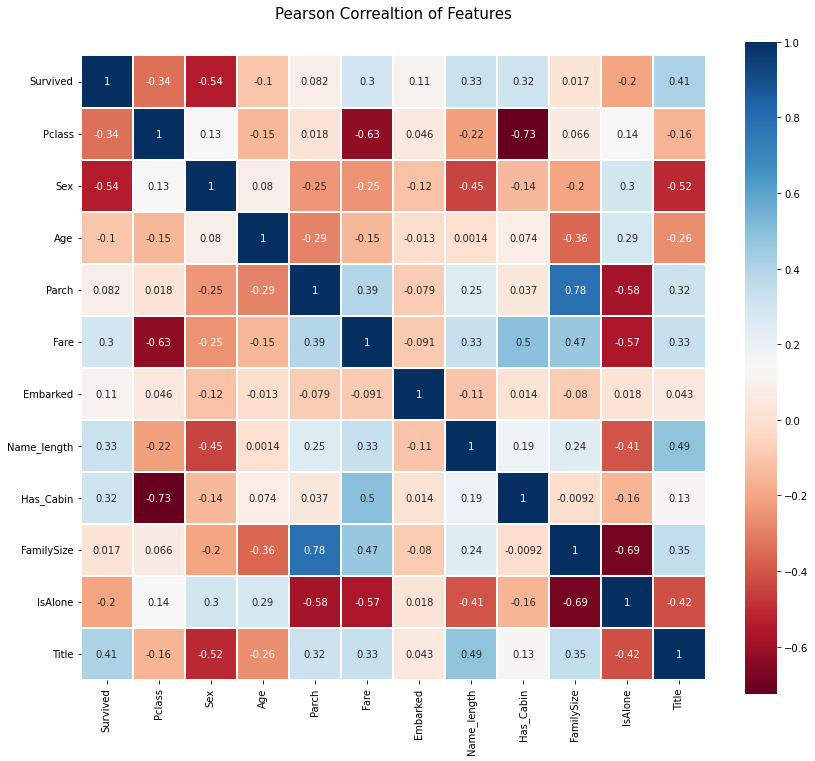

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correaltion of Features', y =1.05, size = 15)
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True)

### Takeaway from the Plots

Pearson Correlation plot이 우리에게 말할 수 있는 한 가지는 서로 강하게 상관된 특성이 너무 많지 않다는 것이다. 

이는 학습 모델에 이러한 기능을 제공한다는 관점에서 보면 좋은데, 그 이유는 훈련 세트에 중복되거나 불필요한 데이터가 많지 않고 각 기능에 고유한 정보가 포함되어 있다는 것을 의미하기 때문이다. 가장 상관관계가 높은 두 가지 기능은 Family size와 Parch(Parents and Children)이다. 이 캐글 노트북의 목적을 위해 두 feature는 모두 그대로 둘 것이다.

(당연히 parch로 familysize를 만들었으니까 높은 거 아님?)

### Pairplots

마지막으로 한 feature에서 다른 feature로의 데이터 분포를 관찰하기 위해 몇 가지 쌍 그림을 생성해 보겠다. 다시 한번 Seaborn을 사용해보자.

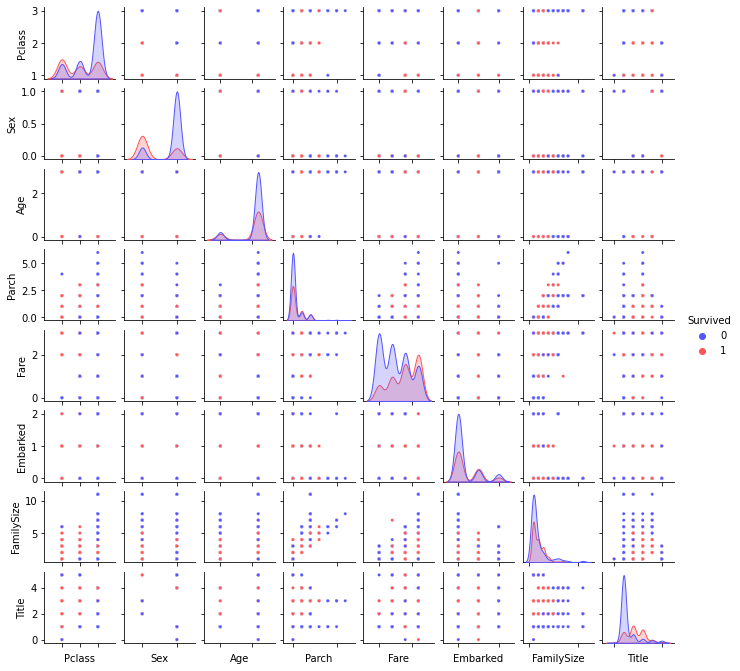

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# 앙상블 및 스태킹 모델
마지막으로 feature engineering 및 형식(formatting) 지정과 관련된 것들을 겪은 후 이 노트북의 핵심과 요지에 도달했다.

스태킹 앙상블 만들기!

## Python 클래스를 통한 Helpers

여기서 우리는 Python의 클래스를 사용하여 보다 편리하게 사용할 수 있도록 할 것이다. 프로그래밍을 처음 접하는 사람은 일반적으로 객체 지향 프로그래밍(OOP)과 함께 사용되는 클래스를 들어 봤을 것이다. 

> **클래스에 대한 설명**\
요컨대, 클래스는 개체(구식 견해에 대한 변수(?))를 생성하기 위한 일부 코드/프로그램을 확장하고 해당 클래스에 특정한 기능과 메서드를 구현하는 데 도움이 된다.

아래 코드 섹션에서 기본적으로 모든 Sklearn 분류기에 공통적으로 내장된 메서드(예: 훈련, 예측 및 맞춤)를 확장할 수 있는 SklearnHelper 클래스를 작성한다. 따라서 5개의 다른 분류기를 호출하려는 경우 동일한 메서드를 5번 작성할 필요가 없으므로 중복성이 제거될 것이다.

In [8]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

**이전에 Python에서 클래스나 객체를 생성해보지 않은 사람들을 위해 위에 제공된 코드가 무엇을 하는지 설명해보도록 하겠다.**

기본 분류자를 만들 때 Sklearn 라이브러리에 이미 있는 모델만 사용하므로 해당 클래스만 확장한다.

**def init** : 클래스의 기본 생성자를 호출하기 위한 Python 표준이다. 이것은 당신이 객체(classifier)를 생성하고자 할 때, clf(원하는 sklearn 분류기), seed(random seed), params(분류기의 매개변수)의 매개변수를 제공해야 함을 의미한다.

나머지 코드는 단순히 sklearn 분류기 내에 이미 존재하는 해당 메서드를 호출하는 클래스의 메서드입니다. 기본적으로 다양한 Sklearn 분류기를 확장하는 wrapper 클래스를 만들었다. 이렇게 하면 여러 학습자를 스태커에 구현할 때 동일한 코드를 반복해서 작성해야 하는 필요성을 줄이는 데 도움이 된다.

### 아웃 오브 폴드 예측

스태킹은 기본 분류기의 예측을 두 번째 모델의 교육을 위한 input으로 사용한다. 그러나 전체 훈련 데이터에서 기본 모델을 훈련하고 전체 테스트 세트에서 예측을 생성한 다음 두 번째 훈련 모델을 돌려볼 수는 없다. 

이는 기본 모델 예측이 이미 테스트 세트를 "본" 상태이므로 이러한 예측을 제공할 때 과적합될 위험이 있기 때문이다.

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# 기본 1단계 모델 생성
이제 첫 번째 분류기로 5개의 학습 모델을 준비하겠다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열된다.

1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

**parameters**

완전성을 위해 여기에 나열할 매개변수에 대한 간략한 요약이다.

**n_jobs** : 학습 프로세스에 사용된 코어 수입니다. -1로 설정하면 모든 코어가 사용된다.

**n_estimators** : 학습 모델의 분류 트리 수(기본값당 10으로 설정)

**max_depth** : 트리의 최대 깊이 또는 노드가 확장되어야 하는 정도. 너무 높게 설정하면 tree가 너무 깊게 들어가므로 과적합의 위험이 있으니 주의해야한다.

**verbose** : 학습 과정에서 텍스트를 출력할지 여부를 제어한다. 값 0은 모든 텍스트를 억제하고 값 3은 모든 반복에서 트리 학습 프로세스를 출력합니다.

전체 설명은 Sklearn 공식 웹사이트를 통해 확인하면 된다. 거기에 다른 유용한 매개변수의 전체 정보가 있다.

In [10]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

또한, OOP 프레임워크 내의 객체 및 클래스에 대해 언급했으므로 이제 앞에서 정의한 Helper Sklearn 클래스를 통해 5개의 학습 모델을 나타내는 5개의 객체를 생성해 보자.

In [11]:
#Create 5 object that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**훈련 및 테스트 세트에서 NumPy 배열 생성**

첫 번째 layer의 기본 모델을 준비했으므로 이제 다음과 같이 원래 데이터 프레임에서 NumPy 배열을 생성하여 분류기에 입력할 훈련 및 테스트 데이터를 준비하자.

In [12]:
#Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

**Output of the First level Predictions**

이제 훈련 및 테스트 데이터를 5개의 기본 분류기에 입력하고 앞서 정의한 Out-of-Fold 예측 function을 사용하여 첫 번째 예측을 해보자. 

아래 코드가 실행되는 데 몇 분 정도 걸린다.

In [13]:
#create our oof train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print('Training is complete')

Training is complete


**다양한 분류기에서 생성된 feature 중요도**

이제 첫 번째 분류기를 학습시켰으므로 Sklearn 모델의 feature를 활용할 수 있다. 즉, 하나의 매우 간단한 코드로 훈련 및 테스트 세트에서 feature들의 중요성을 출력할 수 있다.

Sklearn 문서에 따르면 대부분의 분류기는 .featureimportances를 입력하여 feature 중요도를 반환할 수 있다. 따라서 우리는 이 유용한 속성을 사전에 정의한 함수를 통해 호출하고 feature 중요도를 다음과 같이 표시할 수 있다.

In [14]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_featrue = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.1064844  0.21623876 0.01700785 0.02207294 0.04903379 0.02910638
 0.13583665 0.05025583 0.07068046 0.01174937 0.29153359]
[0.12512135 0.38989169 0.02906058 0.01691803 0.05545158 0.02830627
 0.04749976 0.08535861 0.04669334 0.02142425 0.15427454]
[0.03  0.012 0.002 0.066 0.042 0.01  0.704 0.016 0.046 0.002 0.07 ]
[0.11621754 0.01162595 0.01827525 0.01335208 0.04895842 0.0267722
 0.18664178 0.04169305 0.09532887 0.00485018 0.43628466]


feature 중요도를 할당하고 저장하는 방법을 아직 파악하지 못했기 때문에, 위의 코드에서 값을 복사하여 다음과 같이 Python 목록에 붙여넣어 보자.

In [15]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

Plotly 패키지를 통해 쉽게 플로팅할 수 있도록 feature 중요도 데이터가 포함된 목록의 데이터 프레임을 만들자.

In [16]:
cols = train.columns.values
#Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols,
                                 'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features})

**Plotly 산점도를 통해 알아보는 기능 중요도간의 상호작용**

이 시점에서 상호작용을 나타낼 수 있는 Plotly 패키지를 사용하여 다음과 같이 "Scatter"를 호출해서 플롯 산점도를 통해 다양한 분류기의 기능 중요도 값을 시각화해보자.

In [17]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

이제 모든 특성 중요도의 평균을 계산하고 특성 중요도 데이터 프레임에 새 열로 저장합니다.

In [18]:
#create the new column contatining the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis = 1) #axis = 1 computes the mean row-wise
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028000,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008000,0.038893,0.159062
2,Age,0.044327,0.031296,0.012000,0.072378,0.040000
3,Parch,0.022492,0.015916,0.058667,0.026286,0.030840
4,Fare,0.054326,0.055258,0.032000,0.111944,0.063382


**Plotly Barplot of Average Feature Importances**

모든 분류기에서 평균 feature 중요도를 얻었으므로 다음과 같이 Plotly 막대 플롯으로 플롯할 수 있다.

In [19]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x = x,
              y = y,
              width = 0.5,
              marker = dict(color = feature_dataframe['mean'].values,
                            colorscale = 'Portland',
                            showscale = True,
                            reversescale = False), opacity = 0.6)]
layout = go.Layout(autosize = True,
                  title = 'Barplots of Mean Feature Importance',
                  hovermode = 'closest',
                  xaxis = dict(title = 'Pop',
                              ticklen = 5,
                              zeroline = False,
                              gridwidth = 2,),
                  yaxis = dict(title = 'Feature Importance',
                              ticklen = 5,
                              gridwidth = 2),
                  showlegend = False)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'bar-direct-labels')

# 첫 번째 출력으로 두 번째를 예측하자

**새로운 feature로 사용 되는 1단계 출력 결과**

이제 첫 번째의 예측을 얻었는데, 이는 다음 분류기를 위한 훈련 데이터로 사용할 새로운 feature 세트를 구축하는 것으로 생각할 수 있다. 따라서 아래 코드로 이전 분류기의 첫 번째 예측을 새 column으로 사용하고 이를 이용해 다음 분류기를 훈련해보자.

In [20]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                      'ExtraTrees': et_oof_train.ravel(),
                                      'AdaBoost': ada_oof_train.ravel(),
                                      'GradientBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


**Correlation Heatmap of the Second Level Training set**

In [21]:
data = [
    go.Heatmap(z = base_predictions_train.astype(float).corr().values, 
              x = base_predictions_train.columns.values,
              y = base_predictions_train.columns.values,
              colorscale = 'Viridis',
              showscale = True,
              reversescale = True)]
py.iplot(data, filename = 'labelled-heatmap')


서로 관련이 없는 훈련된 모델이 더 나은 점수를 산출하도록 하는 장점에 대한 기사와 Kaggle 경쟁 우승자 이야기가 꽤 있다.

In [22]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis = 1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis = 1)

이제 첫 번째 학습 및 테스트 예측을 x_train 및 x_test로 연결하고 결합했으므로 이제 두 번째 학습 모델을 예측할 수 있다.

### XGBoost를 통한 2단계 학습 모델
여기에서 매우 유명한 트리 학습 모델인 XGBoost를 선택한다. 
XGBoost는 대규모 부스트 트리 알고리즘을 최적화하기 위해 만들어졌다.  

어쨌든, XGBClassifier를 호출하여 1차 훈련 데이터 및 타겟 데이터에 fit하고 학습된 모델을 사용하여 다음과 같이 테스트 데이터를 예측한다.

In [23]:
gbm = xgb.XGBClassifier(#learning_rate = 0.02,
                       n_estimators = 2000,
                       max_depth = 4,
                       min_child_weight = 2,
                       #gamma = 1,
                       gamma = 0.9,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       objective = 'binary:logistic',
                       nthread = -1,
                       scale_pos_weight = 1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[09:21:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


모델에 사용된 XGBoost 매개변수에 대한 간략한 설명:

max_depth : tree를 얼마나 깊이 키우고 싶은지. 너무 높게 설정하면 과적합의 위험이 있으니 주의하기.

gamma : 트리의 leaf 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소. 클수록 알고리즘이 더 보수적이다.

eta : 과적합을 방지하기 위해 각 부스팅 단계에서 사용되는 단계 크기 축소

**제출 파일 생성**

마지막으로 모든 1단계 및 2단계 모델을 훈련하고 적합하게 하면 이제 다음과 같이 타이타닉 대회에 제출하기 위한 적절한 형식으로 예측을 출력할 수 있다.

In [24]:
#generate Submission File
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                  'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv', index = False)

**추가적으로, 개선을 위한 단계**

위의 단계는 앙상블 스태커를 생성하는 매우 간단한 방법을 보여준다. 쌓인 분류기의 엄청난 조합과 2개 이상의 수준으로 올라가는 쌓기 수준을 포함하는 최고 수준의 Kaggle 대회에서 만들어진 앙상블에 대해 들어봤을 것이다.

점수를 향상시키기 위해 취할 수 있는 몇 가지 추가 단계는 다음과 같다.

1. 최적의 매개변수 값을 찾기 위해 모델을 훈련할 때 좋은 교차 검증 전략 구현
2. 학습을 위한 더 다양한 기본 모델을 소개합니다. 상관 관계가 없는 결과가 많을수록 최종 점수가 더 좋다.

**결론**

이 노트북은 학습 모델을 쌓기 위한 작업 스크립트를 소개하는 데 어느 정도 도움이 되었다. 다시 
일반적으로 스택 또는 앙상블에 대한 다른 우수한 자료는 웹사이트 MLWave: Kaggle Ensembling Guide에서 사실상 반드시 읽어야 하는 기사를 참조하자.